<h5>CITS2402 Practical Assignment, Semester 2 2023</h5><br>

# Exploring Trends in Australian Census Data

---

## Declaration

This declaration should be completed and remain attached to the top of your submission.

*I/we am/are aware of the University’s [policy on academic conduct](https://www.uwa.edu.au/policy/-/media/Project/UWA/UWA/Policy-Library/Policy/Student-Administration/Academic-Integrity/Academic-Integrity-Policy.doc) and I declare that this assignment is entirely the work of the author(s) listed below and that suitable acknowledgement has been made for any sources of information used in preparing it. I have retained a copy for my own records.*

- Name 1: Avery Artemis Warddhana
- Student ID 1: 22984998
- Name 2: Alan Wan
- Student ID 2: 23072152
- Name 3: Renyin Zhang
- Student ID 3: 23719462
- Date:


Remove `_template` from your filename for submission.

<hr>


## Introduction
The topic of rental stress is highly relevant and highly politicised in Australia. Many senior political figures claim that Australia is in a rental crisis and needs to implement a rent freeze for short term relief while others argue that building a long term housing fund is more important (Long, 2023), with the Albanese government in 2023 pledging a number of policies to combat the housing affordability issue (Speers, 2023). One report by Philips (2022) suggests that lower-income Australians were the most impacted in the discussed rental crisis. Nevertheless, Australian voters should be informed on the economic state of rental dwellings, and the impact that major housing policies would have by referring to and analysing the relevant data, from observations across all Australians.

Data analysis was carried out to determine whether the mean rental stress has increased. Rental stress is defined as the share of household income that is spent on housing costs (Australian Bureau of Statistics [ABS], 2022), and for the purposes of this report, includes only the money spent on rent, excluding other miscellaneous living expenses like food, clothing, transport and utilities. Census data packs spanning the years 1996 through 2021 was provided courtesy of the ABS and a selection of data sets, namely weekly income, rent, and dwelling structure type (e.g. detached house, apartment, etc.) was collated and to analyse income and rental stress across on each census year across all Australians and Western Australians specifically.

The aim of this report is to provide objective and relevant information on the perceived rental crisis across income ranges, and to further provide additional contexts and the authors' interpretation of the data as it is modelled. In particular, this investigation was carried out to confirm a hypothesis; that rental stress increases was more prevalent across lower income households than middle or higher-income households.

### Disclaimer
As the provided census data does not reliably provide a mapping from household income to rent, this report will assume that for any given region, income brackets roughly correlates with how much a household pays in rent, e.g. a median-income household will pay about the median cost of rent. This may not be representative of differing housing costs, especially across different regions, as housing in one metropolitan city may be substantially more expensive than a rural city, and also assumes that there is a consistent balance of rent against income across all income brackets. 

Moreover, this investigation considers the household incomes of all Australians, renting or not. This also includes households whose dwellings are occupied outright through a mortgage, life tenure scheme, or other means 

The above assumptions would likely be evident in a skew of the modelled data.

Context and data play pivotal roles in this investigation. Recognising the significance of the hypothesis, the methodology and provenance for sourcing data, and the underlying assumptions made by researchers is essential for comprehending the results presented. This approach serves as a safeguard against misinterpretation, ensuring that both data and statements remain unambiguous. 

In [1]:
import csv
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Census data collection and inspection
As mentioned in the introduction, this report uses data from the ABS, retrieved from its official website. The specific data sources this report are cited with hyperlinks to the original files so that anyone can collate and perform the same analysis. From data inspection, it was found that the ABS has changed the schema of the provided data and its presentation format, and data transforms were needed for this investigation's purposes. To this end, data manipulation and cleaning has been implemented to modify the sourced data for the purposes of this report. However, every effort to ensure that the data was represented faithfully was taken by thoroughly testing the code and manually comparing against the source data. Further information about data provenance can be found under *Data acquisition*. 

## 1996-2006 Census data interpretation
**The following functions serve to extract, clean, transform, and load Australian census data from 1996-2006, potentially from years not mentioned in the second cell. The code takes care to handle irrelevant prologue information, missing values, and merge parts of column names that are spread vertically over multiple cells in the original file. It transforms the cleaned data into a structured format by mapping the data into specific categories and ranges, and then loads the structured data into a Python dictionary with a specific schema. This ensures that the data is accurately transformed and ready for further analysis and reporting.**

### Excel sheet data cleaning
The main function, `extract_raw_census_excel_tsv` extracts the necessary data from the census data packs. The data includes weekly income, rent, and other relevant information from 1996 to 2021. Irrelevant prologue cells containing metadata are skipped to extract the main table, which is then cleaned by handling hierarchical categories and 'Total' rows in the dataset. Special attention is given to properly handle empty values and merge parts of column names that are spread vertically over multiple cells in the original Excel file.

In [2]:
def extract_raw_census_excel_tsv(filename: str) -> tuple[
    list[str],
    dict[str, list[int]],
]:
    """
    Extract the main data table from a specified TSV file that
    is an export of one sheet from a Census Basic Community
    Profile Excel file.

    :returns: a tuple of a list of columns and a dict of rows
    """
    pre_data_fields = []
    with open(filename, newline='') as f:
        reader = csv.reader(f, delimiter='\t', quotechar='"')
        started = False
        for i, row in enumerate(reader):
            # Skip the prologue containing table metadata (copyright, geographic region, etc.)
            if i > 5:
                if any(len(field) > 0 for field in row):
                    started = True
                elif started and all(len(field) == 0 for field in row):
                    break
                pre_data_fields.append(row)

        # Account for some sheets having extra cells after the last column
        last_column_empty = pre_data_fields[-1][-1] == ''
        data = {}
        current_category = None
        for row in reader:
            # Should happen just before the 'Total' row
            if all(len(field) == 0 for field in row):
                break

            row_name = row[0].strip()
            # If we come across a "total" index,
            # it's the end of the current category
            # and store accordingly.
            if row_name == 'Total':
                row_name = current_category + ' ' + row_name
                current_category = None

            rest = row[1:]
            if last_column_empty:
                rest = rest[:-1]
            # If there is a row with an index but no values,
            # it's the mark of a new hierarchical category.
            if all(len(field) == 0 for field in rest):
                if current_category is not None:
                    current_category = current_category + ' ' + row_name
                else:
                    current_category = row_name
                continue

            data[row_name] = [
                int(field.replace(',', ''))
                for field in rest
            ]

    # Long column names in early sheets are spread vertically
    # over multiple cells; must restore to singular strings
    # Occasionally, columns are grouped into categories, which
    # are above the long column names; unfortunately, this information
    # is lost during the conversion since TSV cannot meaningfully store
    # the cell styling used to mark them.
    columns = pre_data_fields[-1][1:]
    # Keep track of columns which are "done" for later.
    done_columns = set()
    for row in reversed(pre_data_fields[:-1]):
        if all(len(field) == 0 for field in row):
            break

        for i, column_part in enumerate(row[1:]):
            if i in done_columns:
                # If there is a string above a completed column name
                # it's a field category and hence it's the end (or start)
                # of the table header
                if len(column_part) > 0:
                    break
                continue

            # If there's no more strings at this index + "height"
            # the column name is complete. Mark it as such.
            if len(column_part) == 0:
                done_columns.add(i)
                continue

            
            columns[i] = column_part + (
                # If it has an ending hyphen, it's a part
                # of a range (particularly dollar ranges in rent data).
                # Don't separate those with a space.
                '' if column_part.endswith('-') else ' '
            ) + columns[i]

    if last_column_empty:
        columns = columns[:-1]
    
    return [column.strip() for column in columns], data

### Tabular data cleaning and structured interpretation
The `parse_1996_census_income`, `parse_census_income`, `parse_1996_census_rent`, and `parse_census_rent` functions transform the cleaned data into a structured format that can be used for further analysis. This involves mapping the data into specific categories and ranges, such as income ranges, household types, and landlord types. The structured data is then output as a Python dictionary with a specific schema, `TableByCategory` that can be used by other parts of the application for analysis and reporting.

In [3]:
def parse_dollar_range(string: str) -> tuple[int, int | None]:
    """
    Extract an integer range from a Census dataset index.
    Example:
        $0-$99 returns (0, 99)
    
    Note: extreme values ($n *or more*) are denoted with a `None`.
    """
    assert string.startswith('$')
    if string.endswith(' or more'):
        lower = string[1:-len(' or more')].replace(',', '')
        lower = int(lower)
        return lower, None
    elif string.endswith(' and over'):
        lower = string[1:-len(' and over')].replace(',', '')
        lower = int(lower)
        return lower, None
    else:
        lower, upper = string.split('-')
        assert upper.startswith('$')
        lower, upper = lower[1:], upper[1:]
        lower, upper = lower.replace(',', ''), upper.replace(',', '')
        lower, upper = int(lower), int(upper)
        return lower, upper

# Sentinel is a Python pattern
# where a unique identity object is used to
# perform checks in contexts where `None`
# would have semantic meaning.
# Create one for skipped columns, since `None`
# is used for 'Not Stated' data points.
KEY_SKIP_SENTINEL = object()

TableByCategory = dict[
    tuple[int | None, int | None] | str | None,
    dict[
        str | tuple[int | None, int | None] | None,
        int,
    ],
]

def parse_1996_census_income(columns: list[str], data: dict[str, list[int]]) -> TableByCategory:
    """
    Given a table of Total Household Incomes extracted from
    the 1996 Census Basic Community Profile, parse and
    restructure it into the schema used by the report code,
    dict[income_range][category] = frequency.
    """
    keys = []
    for i, column in enumerate(columns):
        if column == 'Total':
            keys.append(KEY_SKIP_SENTINEL)
        elif column.startswith('Neg'):
            assert 'Nil' in column
            keys.append((None, 0))
        elif column.startswith('Partial'):
            keys.append('Partial')
        elif 'not stated' in column:
            keys.append(None)
        else:
            keys.append(parse_dollar_range(column))

    result = {
        key: {}
        for key in keys
        if key is not KEY_SKIP_SENTINEL
    }
    for row in ['Family households: Total', 'Non-family households: Total']:
        if row.startswith('Non-'): # Normalise to 2021 DataPack column names
            inner_key = 'Non_family_households'
        else:
            inner_key = 'Family_households'

        values = data[row]
        assert isinstance(values, list)
        for outer_key, v in zip(keys, data[row]):
            if outer_key is KEY_SKIP_SENTINEL:
                continue
            result[outer_key][inner_key] = v

    return result        

def parse_census_income(columns: list[str], data: dict[str, list[int]]) -> TableByCategory:
    """
    Given a table of Total/Gross Household Incomes extracted
    from the 2001/2006 Census Basic Community Profile, parse
    and restructure it into the schema used by the report
    code, dict[income_range][household_type] = frequency.
    """
    keys = []
    for i, column in enumerate(columns):
        if column == 'Total':
            keys.append(KEY_SKIP_SENTINEL)
        elif column.startswith('Non-'): # Normalise to 2021 DataPack column names
            keys.append('Non_family_households')
        else:
            keys.append('Family_households')

    result = {}
    for row, values in data.items():
        assert isinstance(values, list)
        if row.startswith('Neg'):
            assert 'Nil' in row
            outer_key = (None, 0)
        elif row.startswith('Partial'):
            outer_key = 'Partial'
        elif 'not stated' in row:
            outer_key = None
        else:
            outer_key = parse_dollar_range(row)

        assert outer_key not in result
        result[outer_key] = {
            k: v
            for k, v in zip(keys, values)
            if k is not KEY_SKIP_SENTINEL
        }
    return result

def parse_1996_census_rent(columns: list[str], data: dict[str, list[int]]) -> TableByCategory:
    """
    Given a table of Weekly Rent extracted from the 1996
    Census Basic Community Profile, parse and restructure
    it into the schema used by the report code,
    dict[rent_range][income_range] = frequency.
    """
    keys = []
    for column in columns:
        # Handle edge case where the "Weekly rent" category
        # was joined in together with a dollar range column
        if column.startswith('Weekly rent'):
            column = column[len('Weekly rent'):].strip()

        if column == 'Total':
            keys.append(KEY_SKIP_SENTINEL)
        elif column == 'Not stated':
            keys.append(None)
        else:
            keys.append(parse_dollar_range(column))
    result = {
        key: {}
        for key in keys
        if key is not KEY_SKIP_SENTINEL
    }

    for row, values in data.items():
        assert isinstance(values, list)
        if row.startswith('Neg') or row.startswith('Nil'):
            for k, v in zip(keys, values):
                if k is KEY_SKIP_SENTINEL:
                    continue
                current = result[k]
                current[(None, 0)] = current.get((None, 0), 0) + v
            continue

        if row.startswith('Partial'):
            inner_key = 'Partial'
        elif 'ot stated' in row:
            inner_key = None
        else:
            inner_key = parse_dollar_range(row)

        values = data[row]
        assert isinstance(values, list)
        for outer_key, v in zip(keys, data[row]):
            if outer_key is KEY_SKIP_SENTINEL:
                continue
            result[outer_key][inner_key] = v

    return result 

def parse_census_rent(columns: list[str], data: dict[str, list[int]]) -> TableByCategory:
    """
    Given a table of Weekly Rent extracted from the
    2001/2006 Census Basic Community Profile, parse and
    restructure it into the schema used by the report code,
    dict[rent_range][landlord_type] = frequency.
    """
    keys = []
    for i, column in enumerate(columns):
        # Normalise to 2021 DataPack column names
        if column == 'Total':
            keys.append(KEY_SKIP_SENTINEL)
        elif column.startswith('Real') and 'state' in column:
            keys.append('Real_estate_agent')
        elif 'State' in column and 'erritory' in column:
            keys.append('Ste_terr_hsg_auth')
        elif 'not in same household' in column:
            keys.append('Psn_not_Sme_hhd')
        elif 'community' in column:
            keys.append('com_hou_pro')
        elif column.startswith('Other'):
            keys.append('Other')
        elif 'ot' in column and 'tated' in column:
            # Not Stated in different forms of capitalisation
            keys.append(None)
        else:
            raise ValueError(f'Unknown column {column}')

    result = {}
    for row, values in data.items():
        assert isinstance(values, list)
        if row.startswith('Neg'):
            assert 'Nil' in row
            key = (None, 0)
        elif row.startswith('Partial'):
            key = 'Partial'
        elif 'ot stated' in row:
            key = None
        else:
            key = parse_dollar_range(row)

        assert key not in result
        result[key] = {
            k: v
            for k, v in zip(keys, values)
            if k is not KEY_SKIP_SENTINEL
        }

    return result


## 2011-2021 Census data interpretation
**The following functions serve to extract, transform, and load specific segments of the Australian census data from 2011-2021. The code filters out irrelevant columns, extracts and normalizes parts of the column names, and structures the data into a specific format, a nested dictionary of frequency values indexed by income/rent ranges and household/landlord types. It handles different formats of the data, missing values, and edge cases, to ensure the data is accurately transformed and can be used for further analysis and reporting.**

### CSV data extraction
The `parse_census_datapack` function extracts data from a specified Census DataPack CSV file. It uses a user-defined function, `parser`, to parse key-value pairs from the flattened table in the CSV file.

### CSV data cleaning and interpretation
The `parse_income_datapack` and `parse_rent_datapack` functions are specified as the `parser` argument, and transforms the extracted data into a specific schema expected by the report code. This involves filtering out irrelevant columns, extracting and normalising parts of column names, and structuring the data into a specific format (a nested dictionary of frequency values indexed by income/rent ranges, household/landlord types).

The `parse_census_datapack` function outputs the transformed data as a Python dictionary with a specific schema, `TableByCategory`, which can be used by other parts of the application for analysis and reporting.

In [4]:
def parse_income_datapack(column: str, value: str) -> tuple[list[str], int] | None:
    """
    Parse a key-value pair from the 2011-2021 Census DataPack
    CSV into the schema expected by the report code,
    dict[income_range][household_type] = frequency.

    :returns: None if this key-value pair should be skipped, otherwise a tuple of a dictionary path and an integer value.  
    """
    if re.match(r"\w+_CODE_\d{4}", column) is not None:
        return None
    if column.startswith('Tot_'):
        return None
    if column == 'region_id':
        return None

    keys = []
    range_pattern = re.compile(r"HI_(\d+)_(\d+|more)_(.*)")
    if column.startswith('Neg'):
        partitioned = column.split("_", 3)
        assert partitioned[1] == 'Nil'
        assert partitioned[2].startswith('inc')
        keys.append((None, 0))
        rest = partitioned[3]
    elif column.startswith('Part'):
        partitioned = column.split("_", 3)
        assert partitioned[2] in ['stated', 'std']
        keys.append('Partial')
        rest = partitioned[3]
    elif column.startswith('All'):
        partitioned = column.split("_", 3)
        assert partitioned[2] in ['ns', 'not']
        keys.append(None)
        rest = partitioned[3]
        if partitioned[2] == 'not':
            rest = rest[len('stated_'):]
    else:
        result = range_pattern.match(column)
        assert result is not None
        lower = int(result.group(1))
        upper = result.group(2)
        rest = result.group(3)
        try:
            upper = int(upper)
        except:
            upper = None
        keys.append((lower, upper))

    if rest == 'Tot':
        return None

    # Normalise to 2021 DataPack column names
    if rest.startswith('Non_'):
        household_type = 'Non_family_households'
    else:
        household_type = 'Family_households'

    return [*keys, household_type], int(value)

def parse_rent_datapack(column: str, value: str) -> tuple[list[str], int]:
    """
    Parse a key-value pair from the 2011-2021 Census DataPack 
    CSV into the schema expected by the report code,
    dict[rent_range][landlord_type] = frequency.

    :returns: None if this key-value pair should be skipped, otherwise a tuple of a dictionary path and an integer value.  
    """
    if re.match(r"\w+_CODE_\d{4}", column) is not None:
        return None
    if re.match(r"^Tot_(LT_|Tot)", column) is not None:
        return None
    if column == 'region_id':
        return None

    keys = []
    range_pattern = re.compile(r"R_(\d+)_(\d+|ove?r)_(.*)")
    if column.startswith('Rent_ns_'):
        rest = column[len('Rent_ns_'):]
        keys.append(None)
    else:
        result = range_pattern.match(column)
        assert result is not None
        lower = int(result.group(1))
        upper = result.group(2)
        rest = result.group(3)
        try:
            upper = int(upper)
        except:
            upper = None
        keys.append((lower, upper))

    if rest == 'Tot':
        return None

    assert rest.startswith('LT_')
    landlord = rest[len('LT_'):]
    # Normalise to 2021 DataPack column names
    if landlord.startswith('Real_'):
        landlord = 'Real_estate_agent'
    elif landlord.startswith('Ste_'):
        landlord = 'Ste_terr_hsg_auth'
    elif landlord.startswith('com_') or landlord.startswith('hs_coop_'):
        landlord = 'com_hou_pro'
    elif landlord.startswith('Psn_'):
        landlord = 'Psn_not_Sme_hhd'
    elif landlord.startswith('Other_'):
        landlord = 'Other'
    elif landlord == 'Lld_type_ns':
        landlord = None

    return [*keys, landlord], int(value)

def parse_census_datapack(filename: str, parser) -> TableByCategory:
    """
        Parse a specified Census DataPack CSV into the
        schema expected by the report code, using a user-defined
        function which parses a key-value pair from the flattened
        table.

        The parameter `parser` should be typed:
            from typing import Callable
            Callable[[string, string], tuple[list[str], int] | None]
    """
    with open(filename, newline='') as f:
        reader = csv.DictReader(f)
        dicts = list(reader)

    assert len(dicts) == 1
    result = {}
    for column, value in dicts[0].items():
        parsed = parser(column, value)
        if parsed is None:
            continue

        keys, value = parsed
        current = result
        for key in keys[:-1]:
            if key not in current:
                current[key] = {}
            current = current[key]
            assert isinstance(current, dict)

        current[keys[-1]] = value

    return result

## Census data modelling and interpretation
**The following code snippet is responsible for extracting, transforming, and aggregating Australian census data related to income and rent for both Western Australia and Australia as a whole, across multiple years. It extracts the raw data from different files, transforms it into a structured format using predefined functions, and then aggregates the data by summing the frequency values in each category. The final result is a set of dictionaries containing the total income and rent frequencies for each specified range or category, organised by year and region. This structured and aggregated data is essential for further analysis and reporting.**

### Data extraction
The `income_WA`, `income_AUS`, `rent_WA`, and `rent_AUS` dictionaries are created by extracting the raw census data from multiple files spanning different years (1996, 2001, 2006, 2011, 2016, 2021) for each different region (Western Australia, and Australia as a whole).

In [5]:
income_WA = {
    1996: parse_1996_census_income(*extract_raw_census_excel_tsv('./raw_data/1996Census_B23_WA_STE.tsv')),
    2001: parse_census_income(*extract_raw_census_excel_tsv('./raw_data/2001Census_B31_WA_STE.tsv')),
    2006: parse_census_income(*extract_raw_census_excel_tsv('./raw_data/2006Census_B28_WA_STE.tsv')),
    **{
        year: parse_census_datapack(filename, parse_income_datapack) for year, filename in [
            (2011, './raw_data/2011Census_B28_WA_STE_short.csv'),
            (2016, './raw_data/2016Census_G29_WA_STE.csv'),
            (2021, './raw_data/2021Census_G33_WA_STE.csv'),
        ]
    },
}
income_AUS = {
    1996: parse_1996_census_income(*extract_raw_census_excel_tsv('./raw_data/1996Census_B23_AUST.tsv')),
    2001: parse_census_income(*extract_raw_census_excel_tsv('./raw_data/2001Census_B31_AUST.tsv')),
    2006: parse_census_income(*extract_raw_census_excel_tsv('./raw_data/2006Census_B28_AUST.tsv')),
    **{
        year: parse_census_datapack(filename, parse_income_datapack) for year, filename in [
            (2011, './raw_data/2011Census_B28_AUST_short.csv'),
            (2016, './raw_data/2016Census_G29_AUS.csv'),
            (2021, './raw_data/2021Census_G33_AUS_AUS.csv'),
        ]
    },
}

rent_WA = {
    1996: parse_1996_census_rent(*extract_raw_census_excel_tsv('./raw_data/1996Census_B31_WA_STE.tsv')),
    2001: parse_census_rent(*extract_raw_census_excel_tsv('./raw_data/2001Census_B21_WA_STE.tsv')),
    2006: parse_census_rent(*extract_raw_census_excel_tsv('./raw_data/2006Census_B34_WA_STE.tsv')),
    **{
        year: parse_census_datapack(filename, parse_rent_datapack) for year, filename in [
            (2011, './raw_data/2011Census_B34_WA_STE_short.csv'),
            (2016, './raw_data/2016Census_G36_WA_STE.csv'),
            (2021, './raw_data/2021Census_G40_WA_STE.csv'),
        ]
    },
}
rent_AUS = {
    1996: parse_1996_census_rent(*extract_raw_census_excel_tsv('./raw_data/1996Census_B31_AUST.tsv')),
    2001: parse_census_rent(*extract_raw_census_excel_tsv('./raw_data/2001Census_B21_AUST.tsv')),
    2006: parse_census_rent(*extract_raw_census_excel_tsv('./raw_data/2006Census_B34_AUST.tsv')),
    **{
        year: parse_census_datapack(filename, parse_rent_datapack) for year, filename in [
            (2011, './raw_data/2011Census_B34_AUST_short.csv'),
            (2016, './raw_data/2016Census_G36_AUS.csv'),
            (2021, './raw_data/2021Census_G40_AUS_AUS.csv'),
        ]
    },
}

### Aggregating income and rent brackets
The `calculate_totals` function aggregates the data by summing the frequency values in each top-level category of the parsed data, in this case being dollar ranges. The `income_WA_totals`, `income_AUS_totals`, `rent_WA_totals`, and `rent_AUS_totals` dictionaries are created by applying the `calculate_totals` function to each year of data in the `income_WA`, `income_AUS`, `rent_WA`, and `rent_AUS` dictionaries, respectively.

In [6]:
SumTable = dict[
    tuple[int | None, int | None] | str | None,
    int,
]

def calculate_totals(table: TableByCategory) -> SumTable:
    return {
        row: sum(fields.values())
        for row, fields in table.items()
    }

In [7]:
income_WA_totals = {
    year: calculate_totals(table)
    for year, table in income_WA.items()
}
income_AUS_totals = {
    year: calculate_totals(table)
    for year, table in income_AUS.items()
}

In [8]:
rent_WA_totals = {
    year: calculate_totals(table)
    for year, table in rent_WA.items()
}
rent_AUS_totals = {
    year: calculate_totals(table)
    for year, table in rent_AUS.items()
}

### Estimating income and rent
The `percentile_grouped` function takes a summarized frequency distribution table and a specified percentile, and returns an estimate of the value at that percentile using cumulative frequency. The function first sorts the frequency distribution table by the income or rent range (taking into account None values which represent extreme values from the source data, negative or positive infinity). It then calculates the cumulative frequency for each range and determines the range in which the specified percentile falls. Finally, it estimates the precise value at the specified percentile within that range using a linear interpolation method.

In [9]:
def percentile_grouped(table: SumTable, percentile: int) -> float:
    """
    Given a frequency distribution table, estimate the precise value at
    the specified percentile using cumulative frequency.
    """
    sorted_table = sorted(
        [
            (key, count)
            for key, count in table.items()
            if isinstance(key, tuple)
        ],
        key=lambda t: ((
            # `sorted` can handle tuples, but not `None`.
            # Since we used None for extreme values
            # (negative, over a certain dollar amount),
            # we normalise to negative and positive infinity for
            # a strongly consistent sort.
            float('-inf') if t[0][0] is None else t[0][0],
            float('+inf') if t[0][1] is None else t[0][1],
        ))
    )

    
    cumulative = []
    total = 0
    for interval, count in sorted_table:
        total += count
        cumulative.append((interval, count, total))
    assert total == sum(
        count
        for key, count in table.items()
        if isinstance(key, tuple)
    )

    median_range_index = next(
        i
        for i, (_, _, cumulative_freq) in enumerate(cumulative)
        if cumulative_freq >= total * percentile / 100
    )
    median_range, median_freq, _ = cumulative[median_range_index]

    previous_cumulative_freq = 0
    if median_range_index > 0:
        previous_cumulative_freq = cumulative[median_range_index - 1][2]

    lower, upper = median_range
    size = upper - lower

    return lower + (
        (
            (total * percentile / 100) - previous_cumulative_freq
        ) / median_freq
    ) * size

## Modelling income and rent
The code cell calculates the 25th, 50th, and 75th percentiles for income and rent data for both Western Australia (WA) and Australia (AUS) using the `percentile_grouped` function. It then computes the residual income (income after rent) for each percentile and year, and the rental stress (rent as a percentage of income) for each percentile and year. All of these calculations are organised into dictionaries, making it easy to access specific percentiles and years for further analysis.

In [10]:
income_WA_percentiles = {
    percentile: {
        year: percentile_grouped(table, percentile)
        for year, table in income_WA_totals.items()
    }
    for percentile in [25, 50, 75]
}
income_AUS_percentiles = {
    percentile: {
        year: percentile_grouped(table, percentile)
        for year, table in income_AUS_totals.items()
    }
    for percentile in [25, 50, 75]
}

rent_WA_percentiles = {
    percentile: {
        year: percentile_grouped(table, percentile)
        for year, table in rent_WA_totals.items()
    }
    for percentile in [25, 50, 75]
}
rent_AUS_percentiles = {
    percentile: {
        year: percentile_grouped(table, percentile)
        for year, table in rent_AUS_totals.items()
    }
    for percentile in [25, 50, 75]
}

In [11]:
residual_income_WA_percentiles = {
    percentile: {
        year: income - rent_WA_percentiles[percentile][year]
        for year, income in table.items()
    }
    for percentile, table in income_WA_percentiles.items()
}

residual_income_AUS_percentiles = {
    percentile: {
        year: income - rent_AUS_percentiles[percentile][year]
        for year, income in table.items()
    }
    for percentile, table in income_AUS_percentiles.items()
}

## Visualising income and rent

In [12]:
SimpleTable = dict[
    int,
    int,
]
def as_xy(table: SimpleTable) -> tuple[list[int], list[int]]:
    """
    Converts a dictionary table into a list of axes to pass to pyplot
    """
    years, values = list(
        # transpose a sequence of tuples into two sequences  
        zip(*sorted(table.items(), key=lambda i: i[0]))
    )
    return years, values

def as_index(table: SimpleTable) -> tuple[list[int], list[int]]:
    """
    Converts a dictionary table into a list of axes to pass to pyplot
    indexed at 100
    """
    years, values = as_xy(table)
    scale = 100 / values[0]
    return years, [v * scale for v in values]

In [13]:
PERCENTILE_LINE_COLORS = {75: 'g', 50: 'y', 25: 'r'}
def plot_percentile_by_regions(axes, regions, style='-'):
    for ax, percentiles in zip(axes, regions):
        ax.margins(x=0)
        median_x, median_y = as_xy(percentiles[50])
        for percentile, values in percentiles.items():
            x, y = as_xy(values)
            color = PERCENTILE_LINE_COLORS[percentile]
            if percentile != 50:
                ax.fill_between(x, y, median_y, color=color, alpha=0.25)
            ax.plot(x, y, style, label=percentile, color=color)
        ax.set_xticks(median_x)
        ax.set_xticklabels(median_x, rotation=45)

        for line in ax.lines:
            last_x = line.get_xdata()[-1]
            last_y = line.get_ydata()[-1]
            ax.annotate(round(last_y, 2), (last_x, last_y), color=line.get_color())
    
    legend = axes[0].legend()
    legend.set_title('Percentile')

1996 AUS lower class income: 337.21
1996 WA lower class income: 349.98
1996 AUS upper class income: 1079.27
1996 WA upper class income: 1099.98
2021 AUS lower class income: 870.39
2021 WA lower class income: 893.59
2021 AUS upper class income: 2954.04
2021 WA upper class income: 3042.2


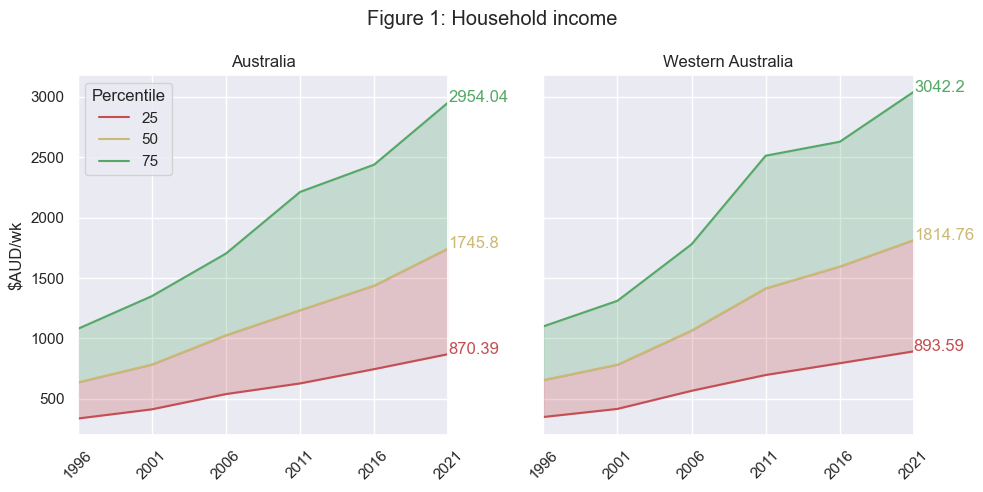

In [14]:
fig, axes = plt.subplots(num=1, nrows=1, ncols=2, sharey=True, figsize=(10, 5))

fig.suptitle(f'Figure {fig.number}: Household income')
axes[0].set_title('Australia')
axes[1].set_title('Western Australia')
axes[0].set_ylabel('$AUD/wk')

plot_percentile_by_regions(axes, [
    income_AUS_percentiles,
    income_WA_percentiles,
])

print("1996 AUS lower class income:", round(income_AUS_percentiles[25][1996], 2))
print("1996 WA lower class income:", round(income_WA_percentiles[25][1996], 2))
print("1996 AUS upper class income:", round(income_AUS_percentiles[75][1996], 2))
print("1996 WA upper class income:", round(income_WA_percentiles[75][1996], 2))
print("2021 AUS lower class income:", round(income_AUS_percentiles[25][2021], 2))
print("2021 WA lower class income:", round(income_WA_percentiles[25][2021], 2))
print("2021 AUS upper class income:", round(income_AUS_percentiles[75][2021], 2))
print("2021 WA upper class income:", round(income_WA_percentiles[75][2021], 2))

fig.tight_layout()
plt.show()

Figure 1 (above) plots the weekly household income over time, linearly interpolated between observations on census years. It shows the range of income between what is defined as the upper class (top quartile, top 25%), the lower class (bottom quartile, top 75%), and the middle class (median, top 50%) for the purposes of this report. Here, weekly income for wealthy households in 1996 is approximately \\$1080, growing to \\$2950 in 2021, for a smoothed annual weekly income growth of about \\$75 per year. In contrast, a low income household in 1996 earns roughly \\$340 weekly whereas in 2021 the same household would earn close to \\$870 weekly for an annual income growth of \\$21.

Evidently, the income growth for upper class households is significantly higher than what the lower class has experienced, indicating an increase of economic inequality on top of the rise of living standards and inflation within the Australian economy. It should be noted that several key historical events, such as the global financial crisis of 2009 or the COVID-19 pandemic, may have impacted several economic observations taken into consideration in this report.

This timeseries data will be used to analyse rental stress and the change in housing affordability for across different income brackets, acknowledging that only the median weekly household income is too general to provide a clear insight, as different income levels are likely to correlate with how high rent a household pays, as lower class households are unlikely to outspend their income in rent, and vice versa.

1996 AUS lower rent: 70.1
1996 WA lower rent: 59.2
1996 AUS upper rent: 176.97
1996 WA upper rent: 163.43
2021 AUS lower rent: 279.4
2021 WA lower rent: 252.08
2021 AUS upper rent: 491.62
2021 WA upper rent: 431.79


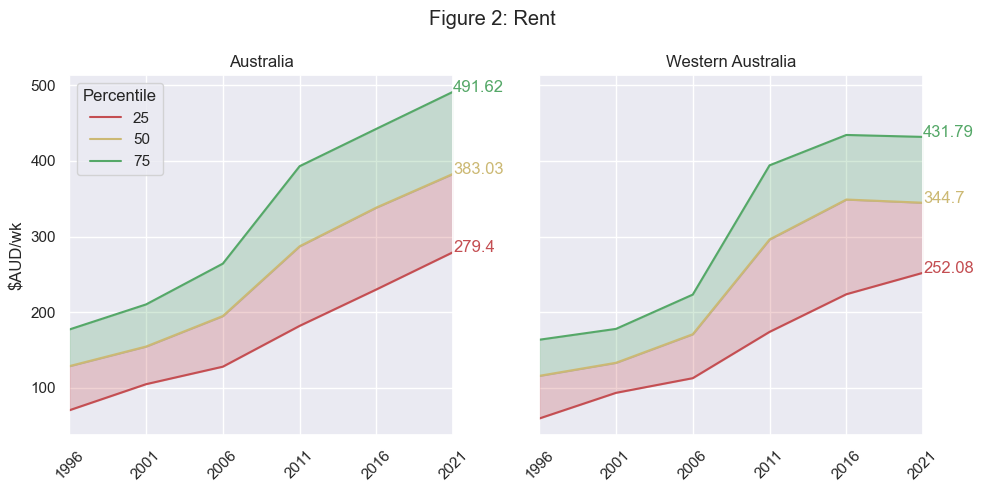

In [15]:
fig, axes = plt.subplots(num=2, nrows=1, ncols=2, sharey=True, figsize=(10, 5))

fig.suptitle(f'Figure {fig.number}: Rent')
axes[0].set_title('Australia')
axes[1].set_title('Western Australia')
axes[0].set_ylabel('$AUD/wk')

plot_percentile_by_regions(axes, [
    rent_AUS_percentiles,
    rent_WA_percentiles,
])

print("1996 AUS lower rent:", round(rent_AUS_percentiles[25][1996], 2))
print("1996 WA lower rent:", round(rent_WA_percentiles[25][1996], 2))
print("1996 AUS upper rent:", round(rent_AUS_percentiles[75][1996], 2))
print("1996 WA upper rent:", round(rent_WA_percentiles[75][1996], 2))
print("2021 AUS lower rent:", round(rent_AUS_percentiles[25][2021], 2))
print("2021 WA lower rent:", round(rent_WA_percentiles[25][2021], 2))
print("2021 AUS upper rent:", round(rent_AUS_percentiles[75][2021], 2))
print("2021 WA upper rent:", round(rent_WA_percentiles[75][2021], 2))

fig.tight_layout()
plt.show()

Figure 2 (above) shows the cost of rent for the top 25%, median, and top 75% of rented dwellings across Australia and Western Australia. Following our assumptions, these rents are paid by their correlating quartile of households, i.e. the upper class of Australians households earning around \\$3000 are paying above \\$400 in rent weekly. Realistically, it is expected that higher income earners would be paying more rent due to the higher amount of disposable income in their possession. However, this is somewhat misleading because it is also logical to assume that some high income earners would not be paying rent at all, and are more likely to have a mortgage or own their dwelling outright, and hence are not classified as renters. As a result, there are many more high income earners who do not pay rent at all than median or low household income earners who do not pay rent. Thus, even though higher income earners may pay more rent, this is more skewed in the averaging process due to the number of potential non-renters in that quartile. It should follow using this graph to understand rental stress among different household income brackets is not entirely accurate which will be taken into account in further analysis.

Despite the inaccuracies, useful insights can be gathered from the data. In 1996, 75% of Australian households paid between \\$70 and \\$177 in rent, a difference of \\$107. By 2021, low income households would have paid \\$279 while high income households paid \\$491, a difference of \\$212. Of note, the rent increases for the bottom 50% of household were faster than for higher income households. This may be as a result of the increase of dwelling costs relative to income (Thomas & Hall, 2016), resulting in an increase of rental dwelling demand, particularly among more lower-income households.

As discussed earlier, the data is skewed due to the households that were considered to pay "zero dollars" of rent. The same principle can be applied here to explain why households with medium and high income roughly match in rental increases up until 2011. In 2011, the cost of rent for households with medium income starts to deviate from the amount high income households pay. Again, this emphasises that more middle income households need to start renting due to increasing cost of housing, likely as one of the consequences of the prior global financial crisis in 2009. This is despite of the National Rental Affordability Scheme, a national government initiative enacted in 2008, which subsidised rental costs (Department of Social Services, 2022). From this interpretation, it follows that the cost of housing is increasingly making owning a house outright through mortgage or otherwise unattainable for more households, and as a result, more households are taking on rent, increasing its demand and further driving up overall housing costs.

While for Australia overall, the rate at which rental costs are growing for all households appears to continually increase, the Western Australian trends appears to plateau in 2016 for households with medium and high income. This may be due to Western Australian government policy enacted and enforced around that time, specifically targeting housing affordability and rental costs.

In [16]:
def fix_overlapping_annotations(ax):
    """
    Within a matplotlib Axes, vertically pace out all
    overlapping child annotations using their bounding box
    """
    annotations = [
        child
        for child in ax.get_children()
        if isinstance(child, matplotlib.text.Annotation)
    ]
    while True:
        modified = False
        for annotation in annotations:
            box = annotation.get_window_extent()
            for other in annotations:
                if other is annotation:
                    continue

                other_box = other.get_window_extent()
                intersection = matplotlib.transforms.Bbox.intersection(box, other_box)
                if intersection is None:
                    continue
                y_intersection = abs(intersection.height)
                if y_intersection < 0.001:
                    continue

                shift = y_intersection / 2 * (1 if box.ymin >= other_box.ymin else -1)
                x, y = 0, shift
                if annotation.anncoords == 'offset pixels':
                    x, y = annotation.xyann
                    y += shift
                annotation.set(anncoords='offset pixels', x=0, y=y)

                x, y = 0, -shift
                if other.anncoords == 'offset pixels':
                    x, y = other.xyann
                    y -= shift
                other.set(anncoords='offset pixels', x=0, y=y)
                modified = True
                break

        if not modified:
            break


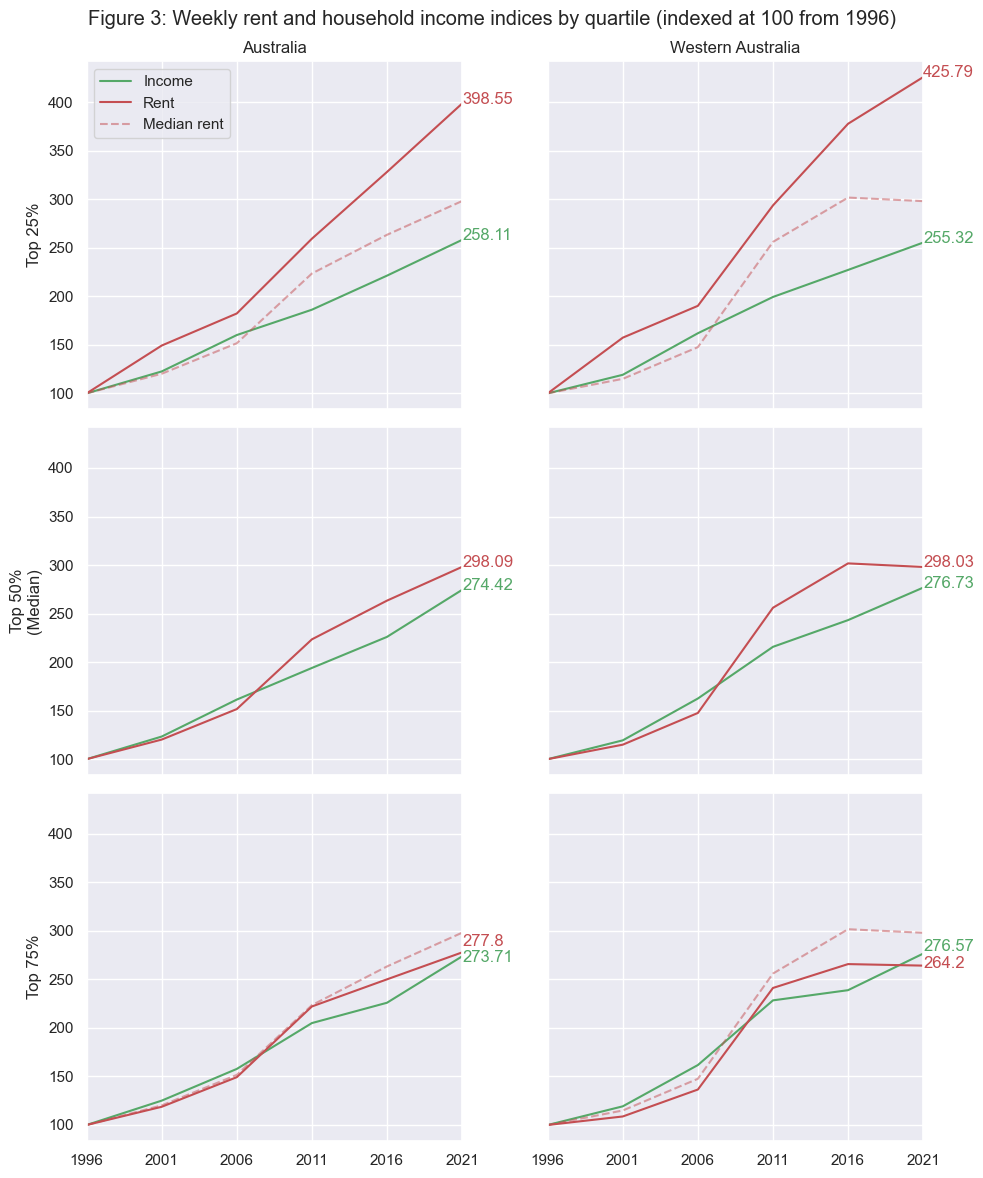

In [17]:
fig, axes = plt.subplots(num=3, nrows=3, ncols=2, sharex=True, sharey=True, figsize=(10,12))

fig.suptitle(f'Figure {fig.number}: Weekly rent and household income indices by quartile (indexed at 100 from 1996)')

axes[0][0].set_title('Australia')
axes[0][1].set_title('Western Australia')
axes[0][0].set_ylabel('Top 25%')
axes[1][0].set_ylabel('Top 50%\n(Median)')
axes[2][0].set_ylabel('Top 75%')
for row, percentile in zip(axes, [25, 50, 75]):
    for ax, (income_percentiles, rent_percentiles) in zip(row, [
        (income_AUS_percentiles, rent_AUS_percentiles),
        (income_WA_percentiles, rent_WA_percentiles),
    ]):
        ax.plot(*as_index(income_percentiles[percentile]), label='Income', color='g')
        ax.plot(*as_index(rent_percentiles[percentile]), label='Rent', color='r')
    if percentile != 50:
        row[0].plot(*as_index(rent_AUS_percentiles[50]), '--', label='Median rent', color='r', alpha=0.5)
        row[1].plot(*as_index(rent_WA_percentiles[50]), '--', label='Median rent', color='r', alpha=0.5)

for i, row in enumerate(axes):
    for ax in row:
        if i == 0:
            xticks = ax.lines[0].get_xdata()
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks, rotation=45)
            ax.margins(x=0)
        for line in ax.lines:
            if line.get_linestyle() == '--':
                continue
            last_x = line.get_xdata()[-1]
            last_y = line.get_ydata()[-1]
            ax.annotate(round(last_y, 2), (last_x, last_y), color=line.get_color())

for row in axes:
    for ax in row:
        fix_overlapping_annotations(ax)

axes[0][0].legend()

fig.tight_layout()
plt.show()

Previously, weekly rent and household income were analysed and interpreted in isolation. Figure 3 (above) shows the two together in order to show how they relate to each other as inflation and standards of living rises, charting an index household income against an index of rent for each quartile respectively.

It can be seen that rent increases appears to usually outpace income growth. This pattern especially evident in 2011, suggesting that most households in Australia are experiencing an growing disparity between their income and the cost of rent, leading to increased rental stress; assuming that a hypothetical high-income Western Australian household pays 30% of their income in rent during 1996, following this graph means that in 2021, their rental stress is closer to half of their total income.

The gap between the median indices is also larger than compared to low-income households, indicating that middle-income households may have a less balanced relationship between their income and rent, although further analysis is needed to draw definitive conclusions.

Note that a macroeconomic level, rent is not the sole factor contributing to the rising financial burden on households and the cost of living. It is well known that the cost of all goods and services is increasing simultaneously, including utility bills and groceries. This not only due to inflation but other economic circumstances. However, this is considered out the scope for this investigation.

In summary, by employing indexed graphs to study the relative changes and trends in income versus rent, a nuanced understanding of how these factors interact over time can be gained. This approach helps us identify evidence, such as the growing gap between income and rent for low-income households, which may be indicative of rental stress in specific segments of the population.

2001 AUS lower rental stress: 25.31
2001 WA lower rental stress: 22.35
2001 AUS upper rental stress: 15.57
2001 WA upper rental stress: 13.55
2021 AUS lower rental stress: 32.1
2021 WA lower rental stress: 28.21
2021 AUS upper rental stress: 16.64
2021 WA upper rental stress: 14.19


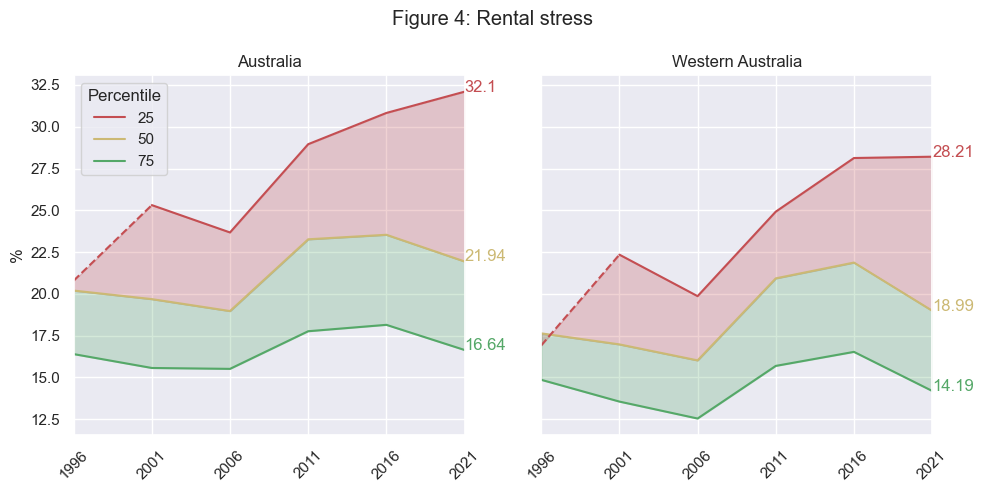

In [18]:
rental_stress_WA_percentiles = {
    percentile: {
        year: rent_WA_percentiles[percentile][year] / income * 100
        for year, income in table.items()
    }
    for percentile, table in income_WA_percentiles.items()
}

rental_stress_AUS_percentiles = {
    percentile: {
        year: rent_AUS_percentiles[percentile][year] / income * 100
        for year, income in table.items()
    }
    for percentile, table in income_AUS_percentiles.items()
}

fig, axes = plt.subplots(num=4, nrows=1, ncols=2, sharey=True, figsize=(10, 5))

fig.suptitle(f'Figure {fig.number}: Rental stress')
axes[0].set_title('Australia')
axes[1].set_title('Western Australia')
axes[0].set_ylabel('%')

plot_percentile_by_regions(axes, [
    rental_stress_AUS_percentiles,
    rental_stress_WA_percentiles,
])

# Denote visible 1996 bottom quartile outlier by redrawing it with a dashed line
for ax in axes:
    lower_quartile = next(line for line in ax.lines if line.get_label() == '25')
    xy = lower_quartile.get_xydata()
    x, y = xy[:, 0], xy[:, 1]
    lower_quartile.set_xdata(x[1:])
    lower_quartile.set_ydata(y[1:])
    ax.plot(x[:2], y[:2], '--', color=line.get_color())

print("2001 AUS lower rental stress:", round(rental_stress_AUS_percentiles[25][2001], 2))
print("2001 WA lower rental stress:", round(rental_stress_WA_percentiles[25][2001], 2))
print("2001 AUS upper rental stress:", round(rental_stress_AUS_percentiles[75][2001], 2))
print("2001 WA upper rental stress:", round(rental_stress_WA_percentiles[75][2001], 2))
print("2021 AUS lower rental stress:", round(rental_stress_AUS_percentiles[25][2021], 2))
print("2021 WA lower rental stress:", round(rental_stress_WA_percentiles[25][2021], 2))
print("2021 AUS upper rental stress:", round(rental_stress_AUS_percentiles[75][2021], 2))
print("2021 WA upper rental stress:", round(rental_stress_WA_percentiles[75][2021], 2))


fig.tight_layout()
plt.show()

Similar to Figure 3, Figure 4 (above) charts rent and income together, by taking the absolute quartile values of rental costs as a percentage of its corresponding household income value, to model rental stress over time. Of note is outlier of lower class household (25th percentile) rental stress in the census year 1996. This is due to the rent datapack from that year considering households which occupy dwellings rent-free as paying $0 dollars in rent, which can disproportionately affect the bottom quartile of rental costs, and is made more apparent when calculating the proportion of household income spent on rent across different classes.

Despite the outlier, the data clearly shows lower-income households suffering a substantial relative increase in rent, increasing from 25% to 32% of their weekly household income, while the disparity between it and rental stress for higher-income households continue to diverge over time, with higher-income households only facing an overall increase of 1%.

However, for 2021, the trend plateaus and actually decreases in the case of middle and high income households, likely as a consequence of the COVID-19 pandemic and the subsequent government policies enacted in its wake. It is not known if this decrease is only temporary or if the rental stress will revert back to the trendline, as this can only be evident in the next census year of 2026.

# Conclusion

Through aggregating the frequency distribution of household income and rent costs extracted from several ABS census datasets, data modelling and interpretation performed throughout this investigation demonstrates that weekly rent and household income have increased across time across all Australians due to inflation and changes in living standards. However, while other Australians faced relatively minor increases in rent relative to their income growth, lower-income Australians who rent, specifically, the bottom 25% of households with regards to income, were clearly disproportionately affected by rental cost increases, thereby confirming the initial hypothesis of this investigation.

# References
Australian Bureau of Statistics \[ABS\]. (1996). B14 DWELLING STRUCTURE BY TENURE TYPE. In *1996 Census Basic Community Profile (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/1996/0

ABS. (1996). B14 DWELLING STRUCTURE BY TENURE TYPE. In *1996 Census Basic Community Profile (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/1996/5

ABS. (1996). B23 HOUSEHOLD TYPE BY WEEKLY HOUSEHOLD INCOME. In *1996 Census Basic Community Profile (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/1996/0

ABS. (1996). B23 HOUSEHOLD TYPE BY WEEKLY HOUSEHOLD INCOME. In *1996 Census Basic Community Profile (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/1996/5

ABS. (1996). B31 WEEKLY HOUSEHOLD INCOME BY WEEKLY RENT. In *1996 Census Basic Community Profile (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/1996/0

ABS. (1996). B31 WEEKLY HOUSEHOLD INCOME BY WEEKLY RENT. In *1996 Census Basic Community Profile (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/1996/5

ABS. (2001). B19 DWELLING STRUCTURE BY TENURE TYPE AND LANDLORD TYPE. In *2001 Census Basic Community Profile (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/2001/0

ABS. (2001). B19 DWELLING STRUCTURE BY TENURE TYPE AND LANDLORD TYPE. In *2001 Census Basic Community Profile (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/2001/5

ABS. (2001). B21 WEEKLY RENT BY LANDLORD TYPE. In *2001 Census Basic Community Profile (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/2001/0

ABS. (2001). B21 WEEKLY RENT BY LANDLORD TYPE. In *2001 Census Basic Community Profile (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/2001/5

ABS. (2001). B31 WEEKLY HOUSEHOLD INCOME BY HOUSEHOLD TYPE. In *2001 Census Basic Community Profile (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/2001/0

ABS. (2001). B31 WEEKLY HOUSEHOLD INCOME BY HOUSEHOLD TYPE. In *2001 Census Basic Community Profile (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/2001/5

ABS. (2006). B28 GROSS HOUSEHOLD INCOME (WEEKLY) BY HOUSEHOLD COMPOSITION. In *2006 Census Basic Community Profile (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/2006/0

ABS. (2006). B28 GROSS HOUSEHOLD INCOME (WEEKLY) BY HOUSEHOLD COMPOSITION. In *2006 Census Basic Community Profile (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/2006/5

ABS. (2006). B32 TENURE TYPE AND LANDLORD TYPE BY DWELLING STRUCTURE. In *2006 Census Basic Community Profile (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/2006/0

ABS. (2006). B32 TENURE TYPE AND LANDLORD TYPE BY DWELLING STRUCTURE. In *2006 Census Basic Community Profile (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/2006/5

ABS. (2006). B34 RENT (WEEKLY) BY LANDLORD TYPE. In *2006 Census Basic Community Profile (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/2006/0

ABS. (2006). B34 RENT (WEEKLY) BY LANDLORD TYPE. In *2006 Census Basic Community Profile (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/community-profiles/2006/5

ABS. (2011). Total Household Income (Weekly) by Household Composition. In *2011 Census Basic Community Profile DataPack (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2011&product=BCP&geography=AU&header=S

ABS. (2011). Total Household Income (Weekly) by Household Composition. In *2011 Census Basic Community Profile DataPack (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2011&product=BCP&geography=STE&header=S

ABS. (2011). Tenure and Landlord Type by Dwelling Structure. In *2011 Census Basic Community Profile DataPack (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2011&product=BCP&geography=AU&header=S

ABS. (2011). Tenure and Landlord Type by Dwelling Structure. In *2011 Census Basic Community Profile DataPack (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2011&product=BCP&geography=STE&header=S

ABS. (2011). Rent (Weekly) by Landlord Type. In *2011 Census Basic Community Profile DataPack (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2011&product=BCP&geography=AU&header=S

ABS. (2011). Rent (Weekly) by Landlord Type. In *2011 Census Basic Community Profile DataPack (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2011&product=BCP&geography=STE&header=S

ABS. (2016). Total Household Income (Weekly) by Household Composition. In *2016 Census General Community Profile DataPack (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2016&product=GCP&geography=AU&header=S

ABS. (2016). Total Household Income (Weekly) by Household Composition. In *2016 Census General Community Profile DataPack (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2016&product=GCP&geography=STE&header=S

ABS. (2016). Tenure and Landlord Type by Dwelling Structure. In *2016 Census General Community Profile DataPack (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2016&product=GCP&geography=AU&header=S

ABS. (2016). Tenure and Landlord Type by Dwelling Structure. In *2016 Census General Community Profile DataPack (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2016&product=GCP&geography=STE&header=S

ABS. (2016). Rent (Weekly) by Landlord Type. In *2016 Census General Community Profile DataPack (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2016&product=GCP&geography=AU&header=S

ABS. (2016). Rent (Weekly) by Landlord Type. In *2016 Census General Community Profile DataPack (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2016&product=GCP&geography=STE&header=S

ABS. (2021). Total Household Income (Weekly) by Household Composition. In *2021 Census General Community Profile DataPack (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2021&product=GCP&geography=AU&header=S

ABS. (2021). Total Household Income (Weekly) by Household Composition. In *2021 Census General Community Profile DataPack (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2021&product=GCP&geography=STE&header=S

ABS. (2021). Tenure and Landlord Type by Dwelling Structure. In *2021 Census General Community Profile DataPack (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2021&product=GCP&geography=AU&header=S

ABS. (2021). Tenure and Landlord Type by Dwelling Structure. In *2021 Census General Community Profile DataPack (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2021&product=GCP&geography=STE&header=S

ABS. (2021). Rent (Weekly) by Landlord Type. In *2021 Census General Community Profile DataPack (Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2021&product=GCP&geography=AU&header=S

ABS. (2021). Rent (Weekly) by Landlord Type. In *2021 Census General Community Profile DataPack (Western Australia)*. Retrieved 23 August, 2023 from https://www.abs.gov.au/census/find-census-data/datapacks?release=2021&product=GCP&geography=STE&header=S

Speers, D. (2023, August 16). From public holidays to rental freeze and housing supply, National Cabinet showed there are limits to Anthony Albanese’s power. https://www.abc.net.au/news/2023-08-17/national-cabinet-albanese-rent-freeze-housing-supply/102737420 

Long, C. (2023, August 25). Should the government freeze rents for two years? The Greens think it is a no-brainer, but economists are less certain. https://www.abc.net.au/news/2022-08-25/should-the-government-freeze-rents-for-two-years-/101369562

ABS. (2022). Housing: Survey of Income and Housing, User Guide, Australia. Retrieved 28 August, 2023 from https://www.abs.gov.au/statistics/detailed-methodology-information/concepts-sources-methods/survey-income-and-housing-user-guide-australia/2019-20/housing#housing-affordability

Australian Government. (2022). National Rental Affordability Scheme. In *Department of Social Services*. Retrieved 9 September, 2023 from https://www.dss.gov.au/our-responsibilities/housing-support/programmes-services/national-rental-affordability-scheme

Thomas, M., Hall, A. (2016, August). Housing affordability in Australia. In *Briefing Book: Key Issues for the 45th Parliament*. 86-89. https://www.aph.gov.au/About_Parliament/Parliamentary_departments/Parliamentary_Library/pubs/BriefingBook45p

Phillips, B. (2023, September 4).  Rent crisis? Average rents are increasing less than you might think. https://theconversation.com/rent-crisis-average-rents-are-increasing-less-than-you-might-think-189154

# Appendix

## Data acquisition
Census data, courtesy of the Australian Bureau of Statistics, was excerpted to gather data points on weekly rent payments, household income and type of household across Australia, and also across Western Australia specifically. However, while recent data was tabulated in the standard Comma Separated Values (CSV) format, some data packs, particularly older data packs up until the census year 2006, was tabulated in XLSX, which cannot be parsed conveniently in Python without forbidden extraneous modules, such as `pandas` or `openpyxl`. Hence, these XLSX files were manually exported to Tab Separated Values (TSV) files using LibreOffice. These TSV files were then saved with the following filename to best conform to the naming scheme from the more modern datapacks:
```
<YEAR>Census_<TABLE-ID>_<REGION-ID>.tsv
```
Examples include:
* `./raw_data/1996Census_B23_WA_STE.tsv`
* `./raw_data/2006Census_B28_AUST.tsv`
